# Logistic and other regressions

In this section we will implement some of the GLMs.

`````{admonition} Task 21
:class: tip
Notice that we are importing one new item from `numpyro.infer` this time: `init_to_median`. Research what it is doing. What are the available alternatives?
`````

In [1]:
import time
import os

import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

import matplotlib.pyplot as plt
import arviz as az

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

rng_key = random.PRNGKey(67)


/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Logistic regression: one dimensional version

Let us simulate some data for Logistic regression and define a logistic regression model using Numpyro. We will need to choose priors for the intercept `alpha` and for the coefficients `beta`. We then will use the NUTS sampler to obtain posterior samples for `alpha` and `beta` from the Bayesian model. Finally, we will print the posterior means of the parameters. 

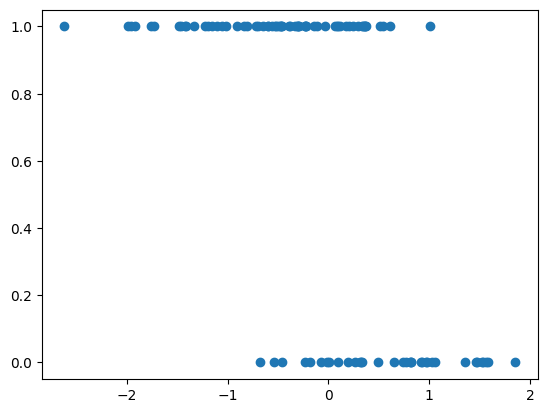

In [2]:
# generate  synthetic data
np.random.seed(42)
X = np.random.randn(100, 1)
true_beta = jnp.array([ -2.0])
true_alpha = 0.5
logits = jnp.dot(X, true_beta) + true_alpha
probs = 1.0 / (1.0 + jnp.exp(-logits))
y = np.random.binomial(1, probs)

plt.scatter(X, y)

In [3]:
# define the logistic regression model
def logistic_regression_model(X, y=None):

    # dimesionality of X, i.e the number of features
    num_features = X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))

    # precompute logits, i.e. the linear predictor
    logits = alpha + jnp.dot(X, beta)

    # likelihood. Remember how to use plates?
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [4]:
# define the number of MCMC samples and the number of warmup steps
num_samples = 1000
num_warmup = 500

# run NUTS 
nuts_kernel = NUTS(logistic_regression_model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, progress_bar=False)

mcmc.run(rng_key, X=X, y=y)



Posterior mean of alpha: 0.73502517

                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.74      0.26      0.73      0.33      1.17    558.38      1.01
   beta[0]     -2.09      0.40     -2.07     -2.70     -1.38    558.49      1.00

Number of divergences: 0


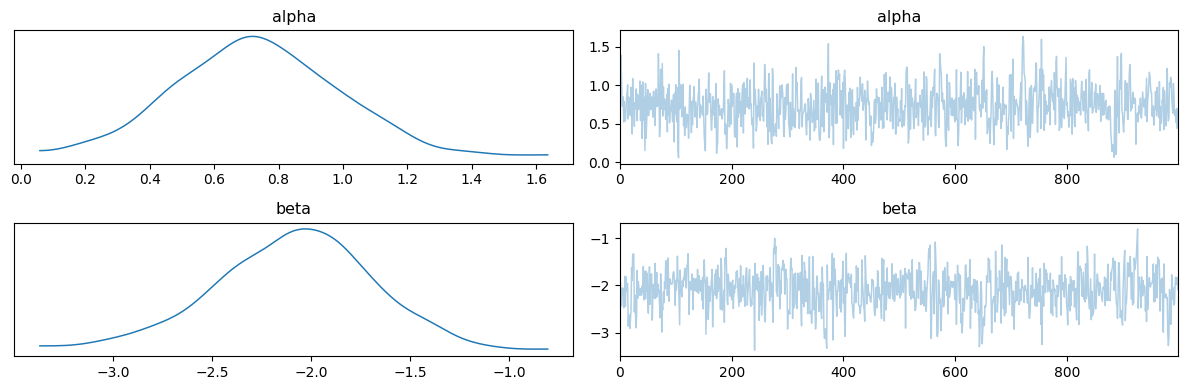

In [5]:
# get posterior samples
samples = mcmc.get_samples()

# print posterior statistics
print("Posterior mean of alpha:", jnp.mean(samples['alpha']))
#print("Posterior mean of beta:", jnp.mean(samples['beta'], axis=0))

# mean is not enough
mcmc.print_summary()

# plot posterior distribution and traceplots
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);
plt.tight_layout()


## Writing a general function for MCMC inference flow

Note that the Numpyro model which we wrote is generic with respect to dimentionality of `X` (well done us!).

However, we have already repeated the same code several times. Let us wrap the inference flow into a function, and then apply to the case with two features and weights.

```{margin}
Notice the `mcmc.print_summary(exclude_deterministic=False)` call. Make sure you understand what it is doing.
```

In [6]:
def run_mcmc(rng_key,       # random key
             model,         # Numpyro model
             args,          # Dictionary of arguments
             verbose=True   # boolean for verbose MCMC
            ):
    
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_mcmc_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False
    )
    start = time.time()
    mcmc.run(rng_key, args)
    t_elapsed = time.time() - start
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    else:
        mcmc.print_summary()

    print("\nMCMC elapsed time:", round(t_elapsed), "s")

    # plot posterior distribution and traceplots
    data = az.from_numpyro(mcmc)
    az.plot_trace(data, compact=True)
    plt.tight_layout()


    return mcmc, mcmc.get_samples(), t_elapsed

As an input, rather than specofocally providing `X` and `y`, we will provide a dictionary `args` with data, as well as other parameters for MCMC.

## Logistic regression: two-dimensional version



In [7]:
# define the logistic regression model
def logistic_regression_model(args): # notice the `args`!

    X = args["X"]
    y = args["y"]

    # dimesionality of X, i.e the number of features
    num_features = X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))

    # precompute logits, i.e. the linear predictor
    logits = alpha + jnp.dot(X, beta)

    # likelihood. Remember how to use plates?
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [8]:
# generate synthetic data
np.random.seed(42)
X = np.random.randn(100, 2)
true_beta = jnp.array([1.0, -2.0])
true_alpha = 0.5
logits = jnp.dot(X, true_beta) + true_alpha
probs = 1.0 / (1.0 + jnp.exp(-logits))
y = np.random.binomial(1, probs)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.65      0.28      0.65      0.17      1.08   3012.00      1.00
   beta[0]      0.86      0.31      0.86      0.36      1.37   3147.52      1.00
   beta[1]     -2.05      0.39     -2.03     -2.67     -1.42   3030.44      1.00

Number of divergences: 0

MCMC elapsed time: 3 s


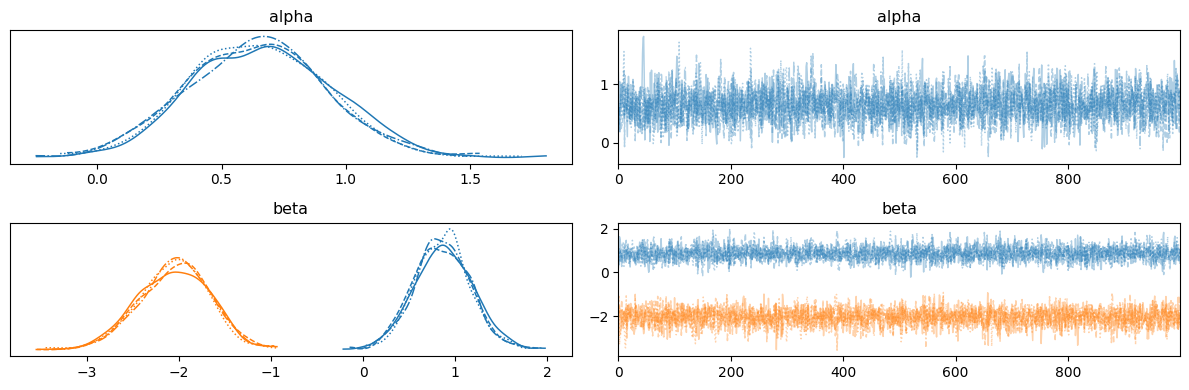

In [9]:
args = {'X': X, 
        'y':y,
        'num_mcmc_samples': 1000,
        'num_warmup': 500,
        'num_chains': 4, 
        'thinning': 1,
}

run_mcmc(rng_key, logistic_regression_model, args);

## Poisson regression

In [10]:
# generate synthetic data
np.random.seed(42)
X = np.random.randn(1000, 2)
true_beta = jnp.array([0.5, -1.5])
true_alpha = 1.0

true_lambda = jnp.exp(true_alpha + jnp.dot(X, true_beta))
y = np.random.poisson(true_lambda)


In [11]:
# define the Poisson regression model
def poisson_regression_model(args):

    X = args["X"]
    y = args["y"]

    # dimesionality of X, i.e the number of features
    num_features = X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    
    # Poisson regression
    lambda_ = jnp.exp(alpha + jnp.dot(X, beta))
    
    # likelihood
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(lambda_), obs=y)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.98      0.02      0.98      0.95      1.02    558.70      1.00
   beta[0]      0.49      0.01      0.49      0.47      0.51   1216.76      1.00
   beta[1]     -1.52      0.01     -1.52     -1.54     -1.50    656.19      1.00

Number of divergences: 0

MCMC elapsed time: 3 s


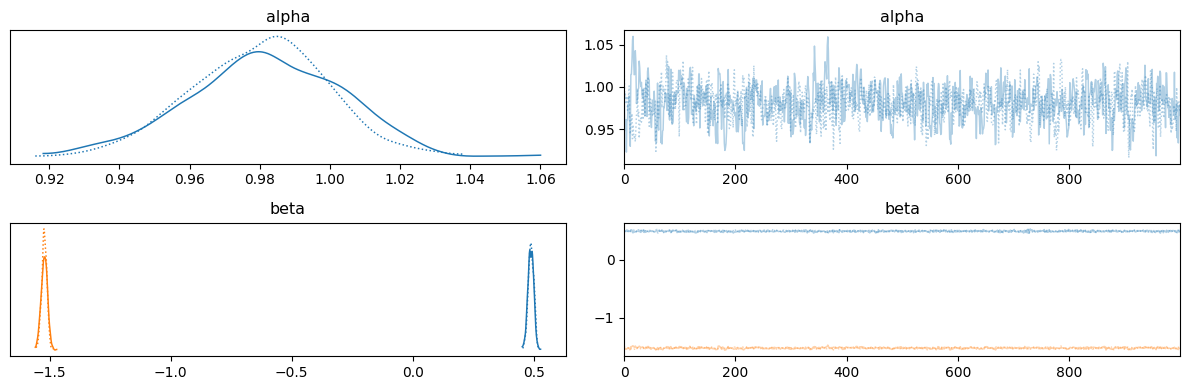

In [12]:
args = {'X': X, 
        'y':y,
        'num_mcmc_samples': 1000,
        'num_warmup': 500,
        'num_chains': 2, 
        'thinning': 1,
}

run_mcmc(rng_key, poisson_regression_model, args);

## Binomial regression

In [13]:
# generate synthetic data
np.random.seed(42)
num_samples = 100
X = np.random.randn(num_samples, 2)
true_beta = np.array([1.0, -2.0])
true_alpha = 1.0
logits = true_alpha + X.dot(true_beta)
num_trials = np.random.randint(1, 10, size=num_samples)  # Vector of different numbers of trials
y = np.random.binomial(num_trials, p=1 / (1 + np.exp(-logits)))

In [14]:
# define the binomial regression model
def binomial_regression_model(args):

    num_samples, num_features = X.shape

    # priors for the coefficients
    alpha = numpyro.sample("alpha", dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))

    # linear predictor
    eta = alpha + jnp.dot(X, beta)

    # Likelihood
    with numpyro.plate('data', num_samples):
        numpyro.sample('obs', dist.Binomial(total_count=num_trials, logits=eta), obs=y)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.78      0.13      0.77      0.56      0.98   1282.27      1.00
   beta[0]      1.07      0.14      1.07      0.84      1.31   1182.81      1.00
   beta[1]     -1.74      0.18     -1.74     -2.03     -1.44   1329.35      1.00

Number of divergences: 0

MCMC elapsed time: 3 s


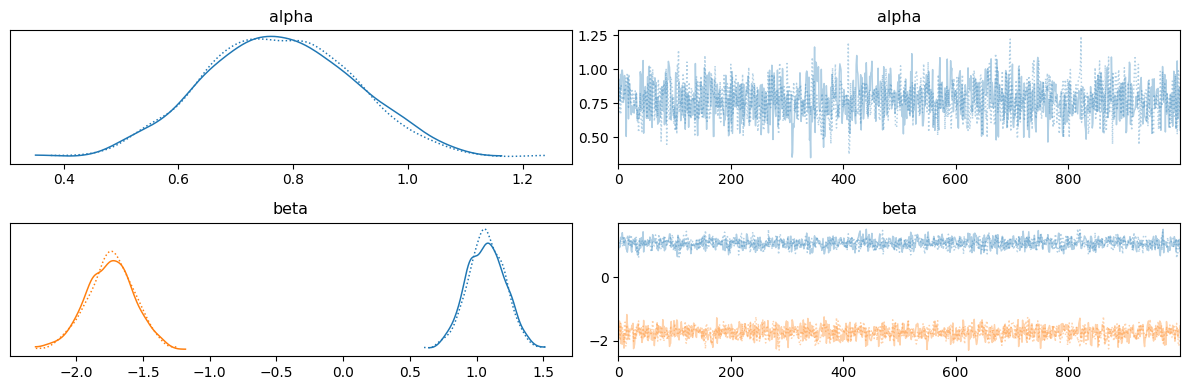

In [15]:
args = {'X': X, 
        'y':y,
        'num_trials': num_trials,
        'num_mcmc_samples': 1000,
        'num_warmup': 500,
        'num_chains': 2, 
        'thinning': 1,
}

run_mcmc(rng_key, binomial_regression_model, args);

## Negative Binomial regression

So far, we have seen only one distribution able to describe counts - the Poisson distribution. While very appealing, this distribution has such a drawback that its mean and variance are equal $E[y] = \text{Var}[y] = \lambda$. This would not always be a good modelling choice!

The <span style="color:orange">negative binomial</span> distribution can serve as an alternative. It is also appropriate for modelling of counts, however, it allows for the mean and variance not to be equal. There exist more than one parametrizations of the negative binomial distribution. The most intuitive one is $\mathcal{NegBin2}$ parametrisation since it connects the mean and varinace in an intuitive way:

$$
\begin{align*}
E[y] &= \mu,\\
\text{Var}[y] &= \mu + \frac{\mu^2}{\phi}.
\end{align*}
$$

In the limit $\phi \to \infty$ one gets the Poisson distribution; $\frac{\mu^2}{\phi}$ is the additional variance of the negative binomial above that of the Poisson. Parameter $\frac{1}{\phi}$ is the <span style="color:orange">overdispersion</span>.

`````{admonition} Group Task
Demonstrate negative binomial regression by following these steps:

- simulate feature matrix `X` of dimensionality (100, 5)
- set true values of the intercept `alpha`, coefficients `beta` and parameter `phi`
- simulate realisations `y` with these values
- construct a Numpyro model to estimate `alpha`, `beta` and `phi` from data `X` and `y` 
- fit a Poisson model to the same data. How do the two fits compare?

`````